# Exploratory Data Analysis (EDA) for CS10 Satellite Image Classification

This notebook performs comprehensive exploratory data analysis to inform CNN model design and training strategy.

In [1]:
# Import essential libraries
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from pathlib import Path
from PIL import Image
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
# Configure dataset paths
BASE_DIR = Path(r"c:\Users\Hyper\Documents\Personal\Hackathons\2025_HacX_Hackathon\frontend\HacX")
TRAIN_DIR = BASE_DIR / "train"
TEST_DIR = BASE_DIR / "test"

CLASSES = ['normal', 'haze', 'smoke']
CLASS_COLORS = {'normal': '#2ecc71', 'haze': '#f39c12', 'smoke': '#e74c3c'}

print(f"Base Directory: {BASE_DIR}")
print(f"Train Directory: {TRAIN_DIR}")
print(f"Test Directory: {TEST_DIR}")

Base Directory: c:\Users\Hyper\Documents\Personal\Hackathons\2025_HacX_Hackathon\frontend\HacX
Train Directory: c:\Users\Hyper\Documents\Personal\Hackathons\2025_HacX_Hackathon\frontend\HacX\train
Test Directory: c:\Users\Hyper\Documents\Personal\Hackathons\2025_HacX_Hackathon\frontend\HacX\test


In [3]:
def load_dataset_info(data_dir, classes):
    """
    Load image file paths and count samples per class.
    
    Args:
        data_dir: Path to the dataset directory
        classes: List of class names
    
    Returns:
        Dictionary with class names as keys and lists of image paths as values
    """
    dataset_info = {cls: [] for cls in classes}
    
    for cls in classes:
        class_dir = data_dir / cls
        if class_dir.exists():
            # Get all image files using case-insensitive matching
            image_paths = []
            for file_path in class_dir.iterdir():
                if file_path.is_file() and file_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp', '.tif']:
                    image_paths.append(file_path)
            
            dataset_info[cls] = image_paths
    
    return dataset_info

# Load training and test datasets
train_data = load_dataset_info(TRAIN_DIR, CLASSES)
test_data = load_dataset_info(TEST_DIR, CLASSES)

## 1. Dataset Overview

In [4]:
# Count samples per class
train_counts = {cls: len(paths) for cls, paths in train_data.items()}
test_counts = {cls: len(paths) for cls, paths in test_data.items()}

# Create summary DataFrame
df_summary = pd.DataFrame({
    'Class': CLASSES,
    'Train Samples': [train_counts[cls] for cls in CLASSES],
    'Test Samples': [test_counts[cls] for cls in CLASSES],
})
df_summary['Total'] = df_summary['Train Samples'] + df_summary['Test Samples']
df_summary['Train %'] = (df_summary['Train Samples'] / df_summary['Train Samples'].sum() * 100).round(2)
df_summary['Test %'] = (df_summary['Test Samples'] / df_summary['Test Samples'].sum() * 100).round(2)

print("="*60)
print("DATASET SUMMARY")
print("="*60)
print(df_summary.to_string(index=False))
print("="*60)
print(f"Total Training Samples: {df_summary['Train Samples'].sum()}")
print(f"Total Test Samples: {df_summary['Test Samples'].sum()}")
print(f"Total Samples: {df_summary['Total'].sum()}")
print("="*60)

DATASET SUMMARY
 Class  Train Samples  Test Samples  Total  Train %  Test %
normal           2524           841   3365    67.60   67.60
  haze            601           200    801    16.10   16.08
 smoke            609           203    812    16.31   16.32
Total Training Samples: 3734
Total Test Samples: 1244
Total Samples: 4978


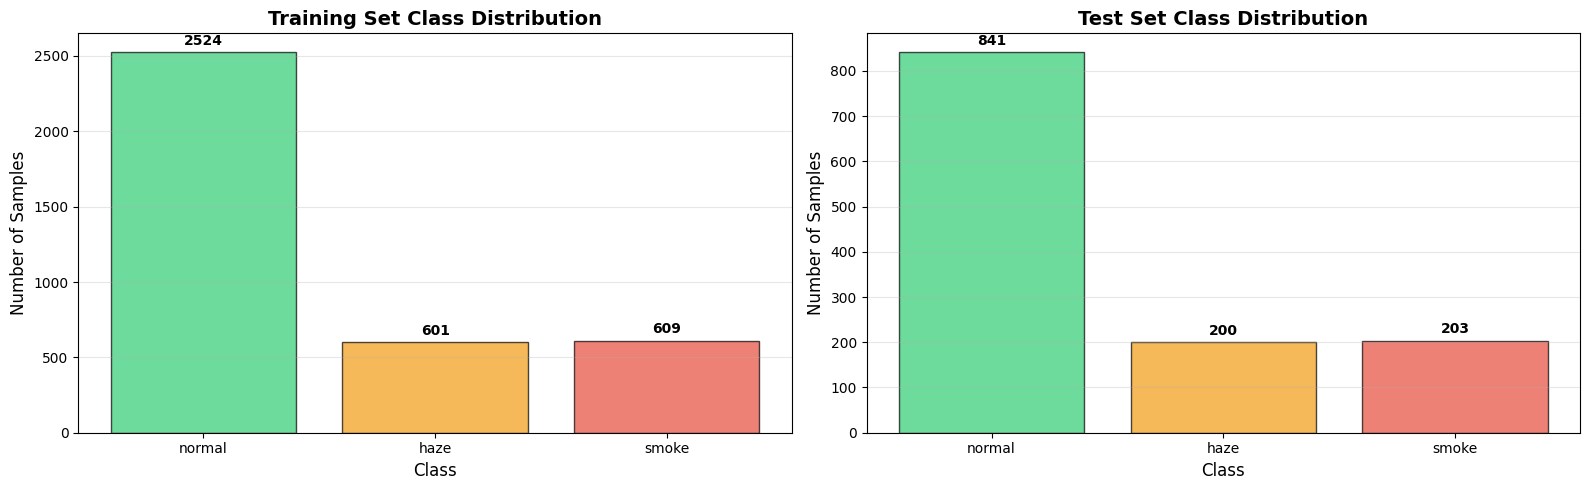

In [5]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Training set distribution
axes[0].bar(CLASSES, [train_counts[cls] for cls in CLASSES], 
           color=[CLASS_COLORS[cls] for cls in CLASSES], alpha=0.7, edgecolor='black')
axes[0].set_title('Training Set Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, cls in enumerate(CLASSES):
    axes[0].text(i, train_counts[cls] + max(train_counts.values())*0.02, 
                str(train_counts[cls]), ha='center', fontweight='bold')

# Test set distribution
axes[1].bar(CLASSES, [test_counts[cls] for cls in CLASSES], 
           color=[CLASS_COLORS[cls] for cls in CLASSES], alpha=0.7, edgecolor='black')
axes[1].set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, cls in enumerate(CLASSES):
    axes[1].text(i, test_counts[cls] + max(test_counts.values())*0.02, 
                str(test_counts[cls]), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

Overview and Key FIndings:
- The dataset exhibits severe class imbalance across both training and test sets. 
    - Training Set:
        - Normal: 2,524 samples (67.60%)
        - Haze: 601 samples (16.10%)
        - Smoke: 609 samples (16.31%)
        - A naive classifier predicting "Normal" could achieve ~67% accuracy without learning meaningful features.
    - Test Set:
        - Normal: 841 samples (67.60%)
        - Haze: 200 samples (16.08%)
        - Smoke: 203 samples (16.32%)
        - Similar imbalance observed, confirming consistent distribution across splits.

Insights: 
- Bias Toward Majority Class: Models trained on this dataset are likely to favor the majority class (Normal), leading to:
    - Poor Recall: Critical for minority classes (Haze and Smoke), which are the primary focus for public safety concerns.
    - Reduced Generalization: Imbalanced data may result in suboptimal performance on real-world scenarios where minority classes are more critical.
- Evaluation Metrics: Accuracy alone is insufficient; metrics like weighted F1-score and per-class recall are essential to assess model performance.

## 2. Dataset Image Properties

In [6]:
def analyze_image_characteristics(data_dict, dataset_name):
    """
    Analyze image dimensions, file formats, and color channels.
    Display results in formatted tables.
    
    Args:
        data_dict: Dictionary with class names and image paths
        dataset_name: Name of the dataset (e.g., 'Train' or 'Test')
    """
    print(f"{'='*60}")
    print(f"{dataset_name} Dataset - Image Characteristics Analysis")
    print(f"{'='*60}\n")
    
    all_results = []
    
    for cls in CLASSES:
        # Track characteristics
        dimensions = []
        formats = []
        color_modes = []
        
        # Analyze all images in this class
        for img_path in data_dict[cls]:
            try:
                with Image.open(img_path) as img:
                    dimensions.append(img.size)
                    formats.append(img.format)
                    color_modes.append(img.mode)
            except Exception as e:
                print(f"Error reading {img_path}: {e}")
        
        # Build summary data
        total_images = len(dimensions)
        
        # Dimensions summary
        dim_counts = {}
        for dim in dimensions:
            dim_str = f"{dim[0]} x {dim[1]}"
            dim_counts[dim_str] = dim_counts.get(dim_str, 0) + 1
        
        # Format summary
        format_counts = {}
        for fmt in formats:
            format_counts[fmt] = format_counts.get(fmt, 0) + 1
        
        # Color mode summary
        mode_counts = {}
        for mode in color_modes:
            mode_desc = "RGB (3 channels)" if mode == "RGB" else "Grayscale (1 channel)" if mode == "L" else mode
            mode_counts[mode_desc] = mode_counts.get(mode_desc, 0) + 1
        
        # Store results
        all_results.append({
            'Class': cls.upper(),
            'Total Images': total_images,
            'Dimensions': ', '.join([f"{k}: {v} ({v/total_images*100:.1f}%)" for k, v in dim_counts.items()]),
            'File Formats': ', '.join([f"{k}: {v} ({v/total_images*100:.1f}%)" for k, v in format_counts.items()]),
            'Color Channels': ', '.join([f"{k}: {v} ({v/total_images*100:.1f}%)" for k, v in mode_counts.items()])
        })
    
    # Create DataFrame and display as table
    df = pd.DataFrame(all_results)
    print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))
    print()


# Run analysis
analyze_image_characteristics(train_data, "TRAIN")
analyze_image_characteristics(test_data, "TEST")


TRAIN Dataset - Image Characteristics Analysis

+---------+----------------+--------------------------+---------------------+---------------------------------+
| Class   |   Total Images | Dimensions               | File Formats        | Color Channels                  |
+=========+================+==========================+=====================+=================================+
| NORMAL  |           2524 | 256 x 256: 2524 (100.0%) | TIFF: 2524 (100.0%) | RGB (3 channels): 2524 (100.0%) |
+---------+----------------+--------------------------+---------------------+---------------------------------+
| HAZE    |            601 | 256 x 256: 601 (100.0%)  | TIFF: 601 (100.0%)  | RGB (3 channels): 601 (100.0%)  |
+---------+----------------+--------------------------+---------------------+---------------------------------+
| SMOKE   |            609 | 256 x 256: 609 (100.0%)  | TIFF: 609 (100.0%)  | RGB (3 channels): 609 (100.0%)  |
+---------+----------------+--------------------------+-

Overview and Key Findings:
- All images are 256×256, TIFF format, RGB with 3 channels—no preprocessing needed for resizing or format conversion.

Insights: 
- Consistent image quality. It simplifies our pipeline, allowing for the focus on model architecture and training strategy.
- Easy transfer learning integration. The 256×256 RGB format aligns well with popular pretrained CNN backbones like ResNet, EfficientNet, or MobileNet. 
- Augmentation Flexibility. Freedom to apply extensive augmentation without fear of mismatched sizes or channel mismatches.
